# Use Agglomerative Clustering to Group stocks with similar beta
The algorithm takes a bottom-up approach where each single data point starts as its own cluster, and then those clusters are grouped together to form larger clusters based on their similarities. The distance measure and linkage criterion determine how similar the clusters are to one another.
The similarity or dissimilarity between individual points is determined by the distance measure, whereas the distance between clusters is determined by the linkage criterion.
we will use the silhouette coefficient which measures the similarity of a single point to its own cluster compared to other clusters.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#import libraries 
import yfinance as yf
import pandas as pd

#initiate the function
def betas(markets, stocks, start_date, end_date):
#download the historical data for the index/market
  market = yf.download(markets, start_date, end_date)
  market['stock_name'] = markets
#calculate daily returns 
  market['daily_return'] = market['Close'].pct_change(1)
#calculate standard deviation of the returns
  market_std = market['daily_return'].std()
  market.dropna(inplace=True)
  market = market[['Close', 'stock_name', 'daily_return']] 
#download the historical data for each stock and calculate its standard deviation 
#using for loops/iteration 
  frames = []
  stds = []
  for i in stocks: 
    data = yf.download(i, start_date, end_date)
    data['stock_name'] = i
    data['daily_return'] = data['Close'].pct_change(1)
    data.dropna(inplace=True)
    data = data[[ 'Close', 'stock_name', 'daily_return']]
    data_std = data['daily_return'].std()
    frames.append(data)
    stds.append(data_std)
#for each stock calculate its correlation with index/market 
  stock_correlation = []
  for i in frames: 
    correlation = i['daily_return'].corr(market['daily_return'])
    stock_correlation.append(correlation)
#calculate beta 
  betas = []
  for b,i in zip(stock_correlation, stds):
    beta_calc = b * (i/market_std)
    betas.append(beta_calc)
#form dataframe with the results 
  dictionary = {stocks[e]: betas[e] for e in range(len(stocks))}
  dataframe = pd.DataFrame([dictionary]).T
  dataframe.reset_index(inplace=True)
  dataframe.rename(
    columns={"index": "Stock_Name", 0: "Beta"},
    inplace=True,)
  return dataframe

In [4]:
companies=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table  = companies[0]
df = table[table["Symbol"].str.contains("BRK.B|BF.B") == False]
ticker_list1 = df['Symbol'].to_list()
ticker_list1[0:]

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',


In [5]:
betas = betas('^GSPC', ticker_list1, '2010-01-01', '2023-01-27')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
betas.describe()

,Beta
count,501.000000
mean,1.037928
std,0.272866
min,0.389888
25%,0.850843
50%,1.037402
75%,1.223379
max,1.910647


As we can observe, the beta values vary between 0.389 and 1.910, a fairly wide range.

However, 50% of betas are equal or below 1.037, and only 25% of stocks have data between 0.853 and 1.037. So it can be expected that the clustering might not be that easy.

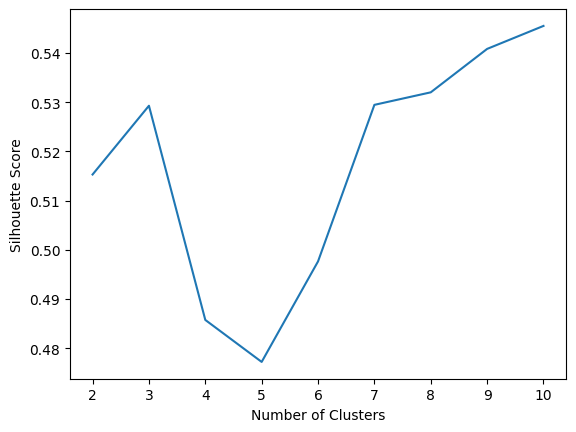

In [7]:
#assigning Beta column to X
X = betas[['Beta']]

#testing number of cluster from 2 to 10 and collecting the silhouette scores
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []
for n_clusters in range_n_clusters:
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    agglom.fit(X)
    labels = agglom.labels_
    scores.append(silhouette_score(X, labels))

#looking at the scores, and their average/mean
scores
average = sum(scores)/len(scores)
average


#graphing 

plt.plot(range_n_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Cluster 1 has 352 observations
Cluster 2 has 149 observations


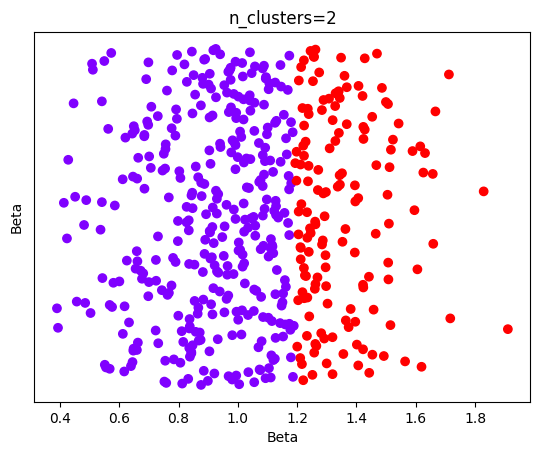

Cluster 1 has 149 observations
Cluster 2 has 247 observations
Cluster 3 has 105 observations


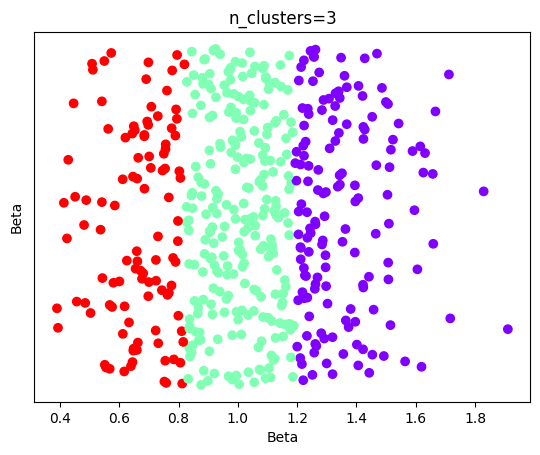

Cluster 1 has 247 observations
Cluster 2 has 52 observations
Cluster 3 has 105 observations
Cluster 4 has 97 observations


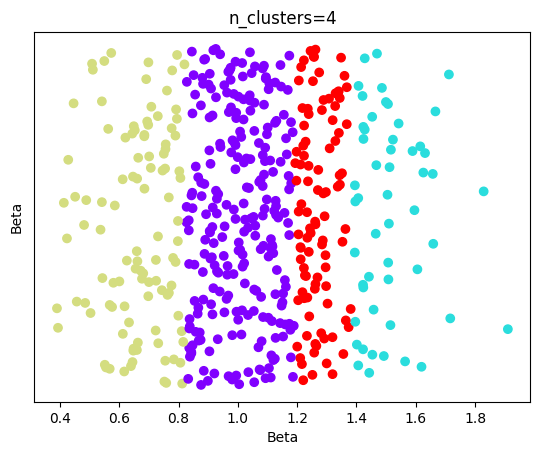

Cluster 1 has 105 observations
Cluster 2 has 52 observations
Cluster 3 has 165 observations
Cluster 4 has 97 observations
Cluster 5 has 82 observations


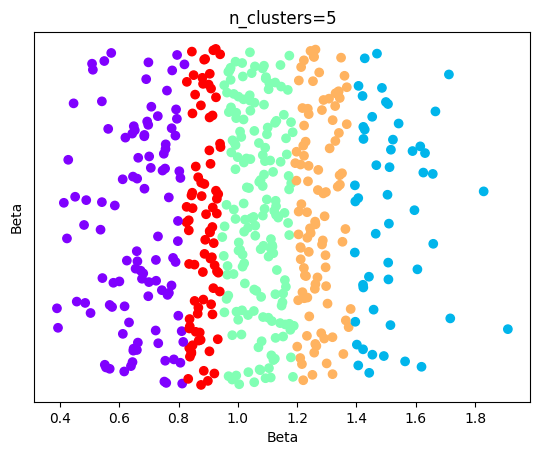

Cluster 1 has 165 observations
Cluster 2 has 52 observations
Cluster 3 has 77 observations
Cluster 4 has 97 observations
Cluster 5 has 82 observations
Cluster 6 has 28 observations


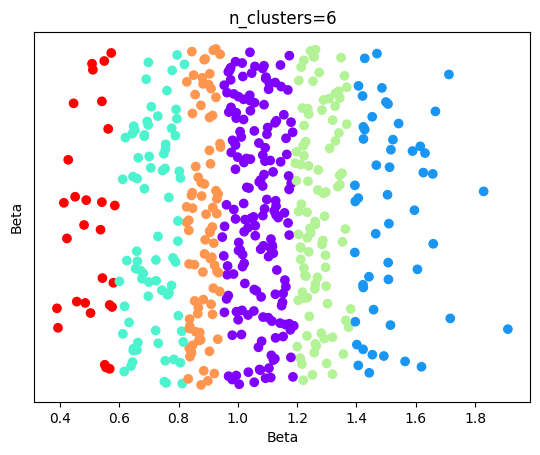

Cluster 1 has 52 observations
Cluster 2 has 97 observations
Cluster 3 has 77 observations
Cluster 4 has 84 observations
Cluster 5 has 82 observations
Cluster 6 has 28 observations
Cluster 7 has 81 observations


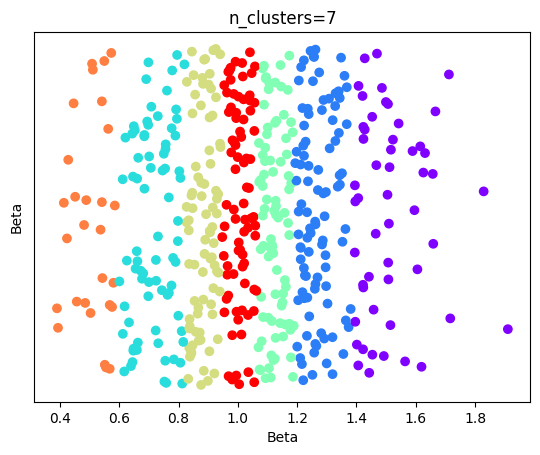

Cluster 1 has 77 observations
Cluster 2 has 97 observations
Cluster 3 has 14 observations
Cluster 4 has 84 observations
Cluster 5 has 82 observations
Cluster 6 has 28 observations
Cluster 7 has 81 observations
Cluster 8 has 38 observations


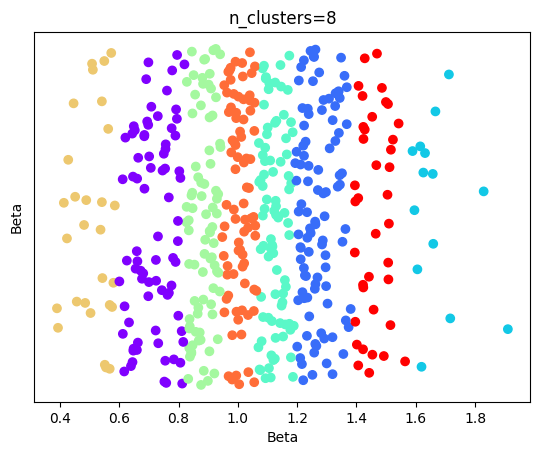

Cluster 1 has 97 observations
Cluster 2 has 84 observations
Cluster 3 has 14 observations
Cluster 4 has 38 observations
Cluster 5 has 82 observations
Cluster 6 has 28 observations
Cluster 7 has 81 observations
Cluster 8 has 38 observations
Cluster 9 has 39 observations


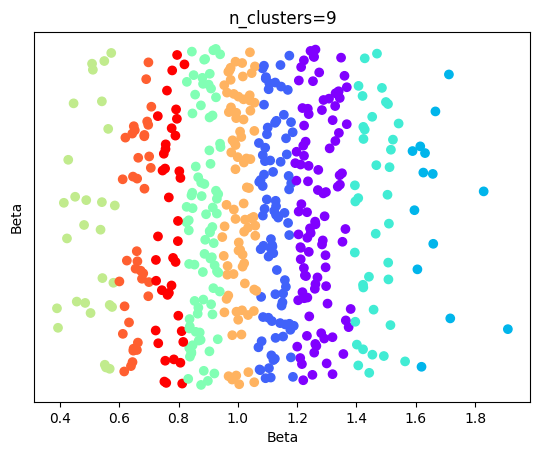

Cluster 1 has 14 observations
Cluster 2 has 84 observations
Cluster 3 has 28 observations
Cluster 4 has 38 observations
Cluster 5 has 82 observations
Cluster 6 has 40 observations
Cluster 7 has 81 observations
Cluster 8 has 38 observations
Cluster 9 has 39 observations
Cluster 10 has 57 observations


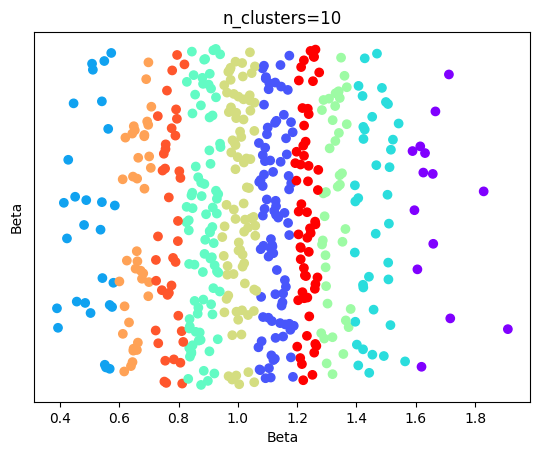

In [8]:
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X)
    # Create scatter plot of data points colored by cluster label
    plt.scatter(X, betas['Stock_Name'], c=labels, cmap='rainbow')
    plt.xlabel('Beta')
    plt.ylabel('Beta')
    plt.title(f"n_clusters={n_clusters}")
    cluster_counts = np.bincount(labels)
    for i in range(n_clusters):
        print(f"Cluster {i+1} has {cluster_counts[i]} observations")
    plt.yticks([])
    plt.show()

In [9]:
optimal_n_clusters = 4
agglom = AgglomerativeClustering(n_clusters=optimal_n_clusters)
cluster_labels = agglom.fit_predict(X)
betas['Cluster'] = cluster_labels
betas

,Stock_Name,Beta,Cluster
0,MMM,0.875892,0
1,AOS,1.004497,0
2,ABT,0.812276,2
3,ABBV,0.758457,2
4,ACN,1.055209,0
...,...,...,...
496,YUM,0.844920,0
497,ZBRA,1.245038,3
498,ZBH,0.917220,0
499,ZION,1.261779,3


In [10]:
type(betas)

pandas.core.frame.DataFrame

c:\Users\anura\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


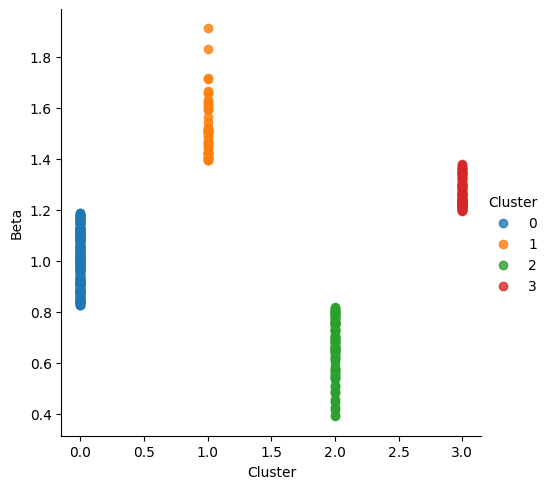

In [11]:
cluster4 = sns.lmplot(data=betas, x='Cluster', y='Beta', hue='Cluster', 
                    legend=True, legend_out=True)

violin plot to show the distribution of each cluster.

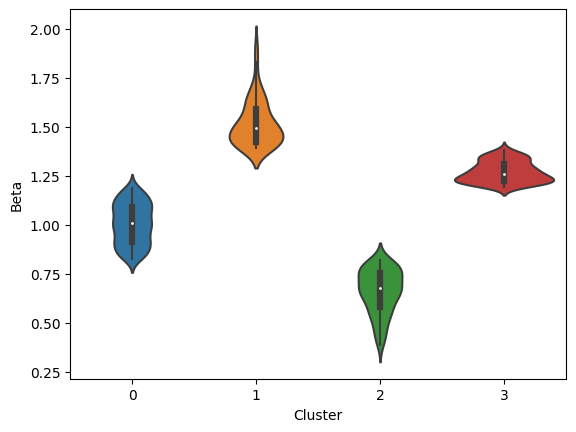

In [12]:
sns.violinplot(x='Cluster', y='Beta', data=betas)
plt.show()

In [13]:
# Save DataFrame to CSV
betas.to_csv('betas_clusters.csv', index=False)